# RAG

Retrieval-Augmented Generation (RAG) é uma técnica que combina modelos de linguagem com mecanismos de recuperação de informações para melhorar a geração de texto.

In [1]:
!pip install -q transformers einops accelerate bitsandbytes
!pip install -q langchain langchain_community langchain-huggingface langchainhub langchain_chroma

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.3/628.3 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 100.6 MB/s eta 0:00

In [3]:
import torch
import os
import getpass
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from langchain_huggingface import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain_core.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder
)
from langchain_core.messages import SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

In [4]:
os.environ["HF_TOKEN"] = getpass.getpass("Enter your HF token:")

Enter your HF token:··········


## Carregando LLM

In [6]:
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config = quantization_config)
tokenizer = AutoTokenizer.from_pretrained(model_id)

pipe = pipeline(model = model, tokenizer = tokenizer, task = 'text-generation', temperature = 0.1,
                max_new_tokens = 512, repetition_penalty = 1.1, return_full_text = False)

llm = HuggingFacePipeline(pipeline = pipe)

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

### Template e Chain

In [10]:
template = """
<|begin_of_text|>
<|start_header_id|>system<|end_header_id|>
Você é um assistente virtual prestativo e está respondendo perguntas gerais.
<|eot_id|>
<|start_header_id|>user<|end_header_id|>
{pergunta}
<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
"""

prompt = PromptTemplate.from_template(template)
chain = prompt | llm
chain.invoke({"pergunta": "Que dia é hoje?"})

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


'Não tenho acesso à data atual. Posso ajudar com algo mais?'

- Aqui vemos o motivo de utilizar RAG, em um contexto sem RAG, é impossível um LLM saber retornar o dia de hoje

## Prompt para RAG - Exemplo simples de implementação

In [72]:
template_rag = """
<|begin_of_text|>
<|start_header_id|>system<|end_header_id|>
Você é um assistente virtual prestativo e está respondendo perguntas gerais.
Use os seguintes pedaços de contexto recuperado para responder à pergunta.
Reponda as perguntas dando a resposta e explicando o porquê.
Se você não sabe a resposta, apenas diga que não sabe. Mantenha a resposta concisa.
<|eot_id|>
<|start_header_id|>user<|end_header_id|>
Pergunta: {pergunta}
Contexto: {contexto}
<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
"""

prompt_rag = PromptTemplate.from_template(template_rag)

### Definindo contexto

In [73]:
from datetime import date

dia = date.today()

contexto = "Você sabe que hoje é dia '{}'".format(dia)

### Criação da Chain e geração do texto

In [74]:
chain_rag = prompt_rag | llm | StrOutputParser()
pergunta = "Que dia é hoje? Retorne a data em formato dd/mm/yyyy"

res = chain_rag.invoke({"pergunta": pergunta, "contexto": contexto})
print(res)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Não tenho acesso ao calendário atual, mas posso dizer que se trata do dia 10/01/2025.


- Apesar de falar que não tem acesso ao calendário, o dia informado está correto

## Explorando RAG - Exemplo um pouco mais complexo

In [75]:
chain_rag = prompt_rag | llm | StrOutputParser()

contexto = """Faturamento trimestral:
1º: R$42476,40
2º: R$46212,97
3º: R$41324,56
4º: R$56430,24"""

pergunta = "Qual trimestre teve o maior faturamento?"

chain_rag.invoke({
  "contexto": contexto,
  "pergunta": pergunta
})

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


'O 4º trimestre teve o maior faturamento. Isso ocorreu porque o valor foi R$ 56430,24, sendo o maior dentre todos os valores apresentados.'

## Depuração / Debugging

Assim como na construção de qualquer tipo de software, em algum momento você precisará depurar ao construir com LLMs. Isso porque uma chamada de modelo falhará ou a saída do modelo será malformatada, ou haverá algumas chamadas de modelo aninhadas e não ficará claro onde ao longo do caminho uma saída incorreta foi criada.
- Definir a depuração = True com que todos os componentes do LangChain com suporte a callback (chains, modelos, agentes, tools, retrievers, etc.) imprimam as entradas que recebem e as saídas que geram. Esta é a configuração mais detalhada e registrará totalmente as entradas e saídas brutas

In [76]:
from langchain.globals import set_debug
set_debug(True)

pergunta = "Qual trimestre teve o menor faturamento?"

chain_rag.invoke({
  "contexto": contexto,
  "pergunta": pergunta
})

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "contexto": "Faturamento trimestral:\n1º: R$42476,40\n2º: R$46212,97\n3º: R$41324,56\n4º: R$56430,24",
  "pergunta": "Qual trimestre teve o menor faturamento?"
}
[chain/start] [chain:RunnableSequence > prompt:PromptTemplate] Entering Prompt run with input:
{
  "contexto": "Faturamento trimestral:\n1º: R$42476,40\n2º: R$46212,97\n3º: R$41324,56\n4º: R$56430,24",
  "pergunta": "Qual trimestre teve o menor faturamento?"
}
[chain/end] [chain:RunnableSequence > prompt:PromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [chain:RunnableSequence > llm:HuggingFacePipeline] Entering LLM run with input:
{
  "prompts": [
    "<|begin_of_text|>\n<|start_header_id|>system<|end_header_id|>\nVocê é um assistente virtual prestativo e está respondendo perguntas gerais.\nUse os seguintes pedaços de contexto recuperado para responder à pergunta.\nReponda as perguntas dando a resposta e explicando o porquê.\nSe v

'O 3º trimestre teve o menor faturamento (R$41324,56). Isso ocorreu porque foi o valor mais baixo dentre os valores apresentados.'

In [77]:
set_debug(False)

# Aplicação em contextos maiores
Nosso próximo exemplo vai consistir de acessar uma página na internet e usar RAG para fazer a LLM "conversar" com ela, usando o seu conteúdo como contexto e assim responder nossas dúvidas. Ou seja, basicamente estaremos fazendo um Webscraping e utilizando o conteúdo lido como contexto

# Arquitetura RAG
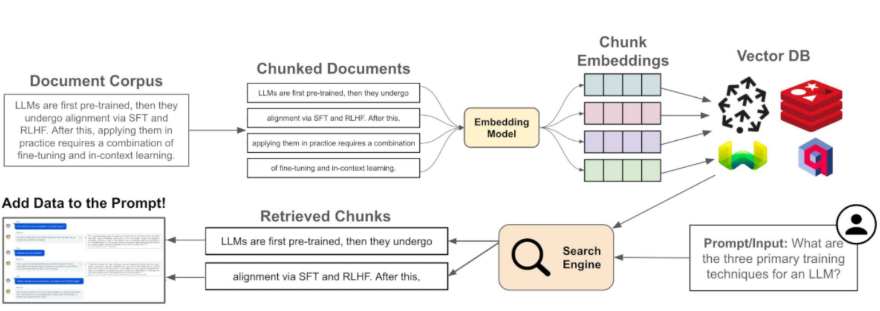

## Etapas de Indexação:
 Etapa de indexação é o processo em que o sistema transforma e organiza os documentos (ou trechos de texto) em uma estrutura que permita recuperá-los de forma ágil e precisa no momento de responder uma pergunta
 ### 1) Carregar o conteúdo

In [20]:
from langchain_community.document_loaders import WebBaseLoader
import bs4
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma

loader = WebBaseLoader(web_paths = ("https://www.bbc.com/portuguese/articles/cd19vexw0y1o",))
docs = loader.load()

In [24]:
docs

[Document(metadata={'source': 'https://www.bbc.com/portuguese/articles/cd19vexw0y1o', 'title': 'Oscar 2024: confira todos os ganhadores dos prêmios da Academia de Hollywood  - BBC News Brasil', 'description': "'Oppenheimer' foi o grande vencedor da noite com sete estatuetas, incluindo o prêmio de melhor filme, melhor diretor e melhor ator.", 'language': 'pt-br'}, page_content="Oscar 2024: confira todos os ganhadores dos prêmios da Academia de Hollywood  - BBC News BrasilBBC News, BrasilVá para o conteúdoSeçõesNotíciasBrasilInternacionalEconomiaSaúdeCiênciaTecnologiaVídeosBBC LêNotíciasBrasilInternacionalEconomiaSaúdeCiênciaTecnologiaVídeosBBC LêOscar 2024: confira todos os ganhadores dos prêmios da Academia de HollywoodCrédito, Getty ImagesLegenda da foto, Robert Downey Jr., Da'Vine Hoy Randolph, Emma Stone e Cillian Murphy com suas respectivas estatuetas do OscarArticle informationAuthor, Leire VentasRole,  Correspondente da BBC News Mundo em Los AngelesTwitter, @leire_ventas11 março 

In [26]:
len(docs[0].page_content)

11962

### 2) Divisão em trechos (Chunks):
Geralmente, o corpus (conjunto de documentos) é separado em partes menores, chamadas de “chunks”, para facilitar a busca. Isso evita que as consultas sejam comparadas a textos muito grandes de uma só vez.

In [78]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
#dividir o texto em pedaços com 1000 caracteres; 200 caracters vão se sobrepor para que não perca informação
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 5000, chunk_overlap = 600, add_start_index = True)
splits = text_splitter.split_documents(docs)
len(splits)

3

In [79]:
splits[1].metadata

{'source': 'https://www.bbc.com/portuguese/articles/cd19vexw0y1o',
 'title': 'Oscar 2024: confira todos os ganhadores dos prêmios da Academia de Hollywood  - BBC News Brasil',
 'description': "'Oppenheimer' foi o grande vencedor da noite com sete estatuetas, incluindo o prêmio de melhor filme, melhor diretor e melhor ator.",
 'language': 'pt-br',
 'start_index': 4401}

### 3) Armazenamento em uma estrutura de índice:

Os vetores (embeddings) são armazenados em um índice especializado, muitas vezes chamado de vector store ou vector database. Cada embedding costuma ser armazenada junto com metadados (por exemplo, título, autor, link para o documento original) para que, depois de recuperado, seja possível saber de onde veio aquele trecho.
#### Criando embeddings:

In [33]:
hf_embedding = HuggingFaceEmbeddings(model_name = "sentence-transformers/all-mpnet-base-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Aplicando embeddings no texto e armazenando no banco de dados vetorial (Chroma)

In [80]:
vector_store = Chroma.from_documents(documents = splits, embedding = hf_embedding)

### 4) Recuperação dos trechos relevantes:
Os trechos (chunks) com maior similaridade são retornados como contexto para a etapa de geração de resposta.
É nessa combinação dos trechos recuperados com o modelo de linguagem que o RAG se destaca, oferecendo respostas mais embasadas e atualizadas.

### Exemplos de Busca por Similaridade
• Consiste em encontrar documentos ou
informações que são semelhantes a uma consulta
baseada em suas representações numéricas.

• Busca por Similaridade: Compara os vetores
numéricos (embeddings) da consulta e dos
documentos para encontrar os mais semelhantes
via KNN.

• Similaridade Cosseno: método que mede o cosseno do ângulo
entre dois vetores. Quanto maior a similaridade cosseno, mais
semelhantes são os vetores.

• Como buscar um livro em uma biblioteca descrevendo seu
conteúdo. O sistema encontra livros com conteúdos semelhantes
à sua descrição comparando as representações numéricas dos
conteúdos dos livros.

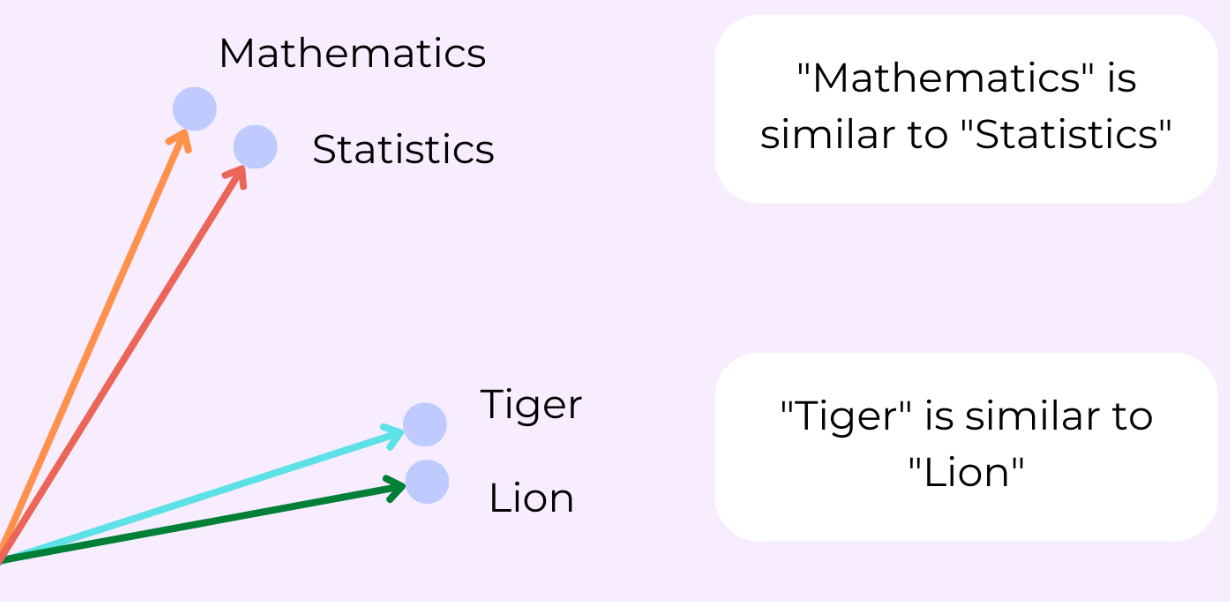

#### Configurando text retriever

In [81]:
retriever = vector_store.as_retriever(search_type = "similarity", search_kwargs = {"k": 9})

### 5) Geração dos textos

In [82]:
prompt_rag = PromptTemplate(
    input_variables=["contexto", "pergunta"],
    template=template_rag,
)
prompt_rag

PromptTemplate(input_variables=['contexto', 'pergunta'], input_types={}, partial_variables={}, template='\n<|begin_of_text|>\n<|start_header_id|>system<|end_header_id|>\nVocê é um assistente virtual prestativo e está respondendo perguntas gerais.\nUse os seguintes pedaços de contexto recuperado para responder à pergunta.\nReponda as perguntas dando a resposta e explicando o porquê.\nSe você não sabe a resposta, apenas diga que não sabe. Mantenha a resposta concisa.\n<|eot_id|>\n<|start_header_id|>user<|end_header_id|>\nPergunta: {pergunta}\nContexto: {contexto}\n<|eot_id|>\n<|start_header_id|>assistant<|end_header_id|>\n')

In [83]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [84]:
chain_rag = ({"contexto": retriever | format_docs, "pergunta": RunnablePassthrough()} | prompt_rag | llm | StrOutputParser())

#### Teste sem RAG

In [85]:
chain.invoke("Qual o filme mais ganhou oscars na premiação de 2024?")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


'Não tenho acesso a informações em tempo real ou futuras. Não posso fornecer informações sobre a premiação do Oscar de 2024, pois não foi realizada ainda. Posso ajudar com algo mais?'

In [86]:
chain_rag.invoke("Qual filme ganhou mais oscars na premiação de 2024?")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


'O filme "Oppenheimer" ganhou mais Oscars na premiação de 2024.'

In [87]:
chain_rag.invoke("Quem ganhou o premio de melhor ator?")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


'O ator que ganhou o prêmio de melhor ator foi Cillian Murphy por sua atuação em "Oppenheimer".'

In [89]:
vector_store.delete_collection()